In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
# Check current directory
current_directory = os.getcwd()

# Specify the file path
file_name = "tiki.csv"
file_path = os.path.join(current_directory, file_name)
df = pd.read_csv(file_path)
print(df.dtypes)
print(df.head())

Link        object
Name        object
Brand       object
Price       object
Sale        object
Stars      float64
Coupon      object
5 stars    float64
4 stars    float64
3 stars    float64
2 stars    float64
1 star     float64
Reviews     object
dtype: object
                                                Link  \
0  https://tiki.vn/bo-noi-inox-3-day-sunhouse-sh3...   
1  https://tiki.vn/bo-noi-inox-3-day-sunhouse-sh3...   
2  https://tiki.vn/noi-hap-inox-3-tang-p129143705...   
3  https://tiki.vn/chao-chong-dinh-inox-day-tu-ng...   
4  https://tiki.vn/chao-sau-long-nag2653-day-tu-5...   

                                                Name     Brand     Price  \
0  Bộ Nồi Inox 3 Đáy Sunhouse SH335(16cm, 20cm, ...  Sunhouse  445.000₫   
1                   Bộ Nồi Inox 3 Đáy Sunhouse SH334  Sunhouse  536.000₫   
2                                Nồi Hấp Inox 3 Tầng       OEM  132.000₫   
3  Chảo chống dính Inox đáy từ nguyên khối đáy li...    Elmich  331.000₫   
4  Chảo Sâu Lòng NAG26

In [3]:
# CLEAN DATA
# Delete empty reviews 
df['Reviews'] = df['Reviews'].astype(str)
reviews = df[['Reviews']]
for index, row in df.iterrows():
    reviews_array = row['Reviews']  # Access the 'Reviews' array for each row
    # Remove square brackets and split into individual reviews
    reviews = reviews_array[2:-2].split("', '")
    new_review = []
    for review in reviews:
        if review == "":
            new_review.append(review)
    row['Reviews'] = new_review


In [4]:
# Add danh muc
df.loc[:9, 'Category'] =  1 #'Dụng cụ nhà bếp'
df.loc[10:19, 'Category'] = 2 #'Trang trí nhà cửa'
df.loc[20:29, 'Category'] = 3 #'Đồ dùng phòng ngủ'
df.loc[30:39, 'Category'] = 4 #'Ngoài trời sân vườn'
df.loc[40:49, 'Category'] = 5 #'Đồ nội thất'

In [5]:
# Impute missing value 
# Choose specific columns
selected_columns = ['5 stars', '4 stars', '3 stars', '2 stars', '1 star', 'Stars']

# Iterate through selected columns and impute missing values with column means
for column in selected_columns:
    mean_value = df[column].mean()
    df[column].fillna(mean_value, inplace=True)

In [6]:
# Word to count in each cell of the 'coupon' column
word_to_count = 'Giảm'

# Function to count occurrences of a word in a string
def count_word_occurrences(text, word):
    if isinstance(text, str):  # Check if the value is a string
        return sum(1 for w in text.split() if w == word)
    else:
        return 0 

# Add a new column 'number_of_coupon' counting occurrences of the word
df['Number of coupon'] = df['Coupon'].apply(lambda x: count_word_occurrences(x, word_to_count))

In [7]:
# Convert numerical data to number (price, stars, sale)
# Convert price to int
df['Price'] = df['Price'].astype(str) # turn object to str
df['Price'] = df['Price'].str.replace(r'\D', '', regex=True).astype(float) # remove character

# Convert sale to int
df['Sale'] = df['Sale'].astype(str) # turn object to str
df['Sale'] = df['Sale'].str.replace(r'\D', '', regex=True).astype(float) # remove character

# Convert the '5 stars', .. '1 star' column to integers only if it's not null,
df[['5 stars', '4 stars', '3 stars', '2 stars', '1 star']] = df[['5 stars', '4 stars', '3 stars', '2 stars', '1 star']].apply(
    lambda x: pd.to_numeric(x, errors='coerce').astype(float)
) 

In [8]:
# Check if there are any null values
print(df.isnull().sum())

# Check columns to make sure you have features and a target variable
df.info()

Link                 0
Name                 0
Brand                0
Price                0
Sale                 0
Stars                0
Coupon              22
5 stars              0
4 stars              0
3 stars              0
2 stars              0
1 star               0
Reviews              0
Category             0
Number of coupon     0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Link              50 non-null     object 
 1   Name              50 non-null     object 
 2   Brand             50 non-null     object 
 3   Price             50 non-null     float64
 4   Sale              50 non-null     float64
 5   Stars             50 non-null     float64
 6   Coupon            28 non-null     object 
 7   5 stars           50 non-null     float64
 8   4 stars           50 non-null     float64
 9   3 stars          

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

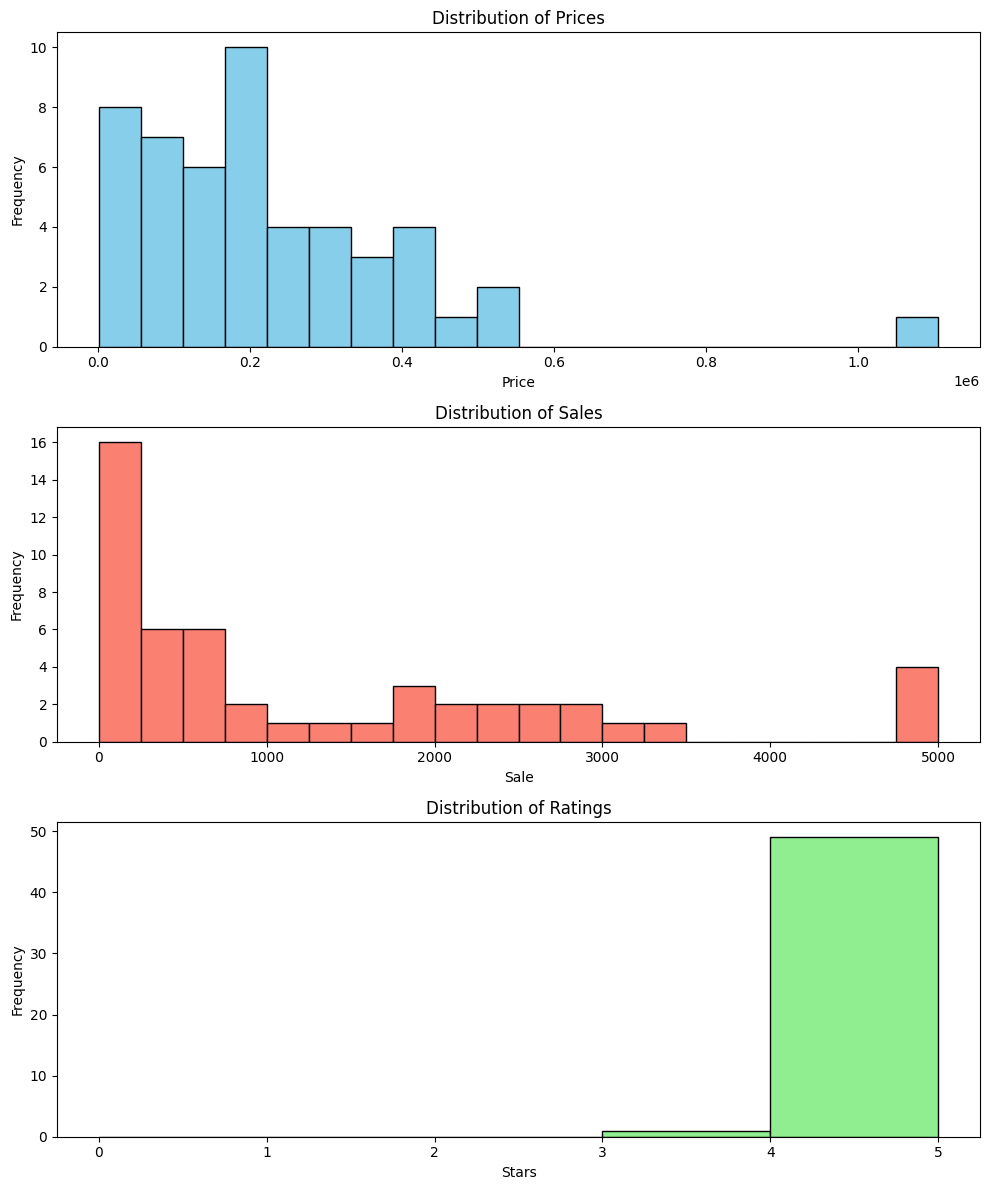

In [10]:
# DESCRIPTIVE STATISTICS
# Plot histograms
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))

# Histogram for 'Price'
axes[0].hist(df['Price'], bins=20, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution of Prices')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Frequency')

# Histogram for 'Sale'
axes[1].hist(df['Sale'].dropna(), bins=20, color='salmon', edgecolor='black')
axes[1].set_title('Distribution of Sales')
axes[1].set_xlabel('Sale')
axes[1].set_ylabel('Frequency')

# Histogram for 'Stars'
axes[2].hist(df['Stars'].dropna(), bins=5, range=(0, 5), color='lightgreen', edgecolor='black')
axes[2].set_title('Distribution of Ratings')
axes[2].set_xlabel('Stars')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [11]:
# Summary count, mean, std, min, max, 25% quantile, 50% quantile, 75% quantile 
selected_columns = ['Price', 'Sale', 'Stars']

summary_table = df[selected_columns].describe().transpose()

# Display the summary table
print("Summary Statistics:")
print(summary_table)

Summary Statistics:
       count           mean            std     min      25%            50%  \
Price   50.0  224097.820000  189062.398407  1800.0  90500.0  184500.000000   
Sale    50.0    1314.200000    1477.710073     1.0    189.5     574.000000   
Stars   50.0       4.673913       0.228066     3.9      4.5       4.673913   

            75%        max  
Price  325000.0  1105000.0  
Sale     2141.0     5000.0  
Stars       4.8        5.0  


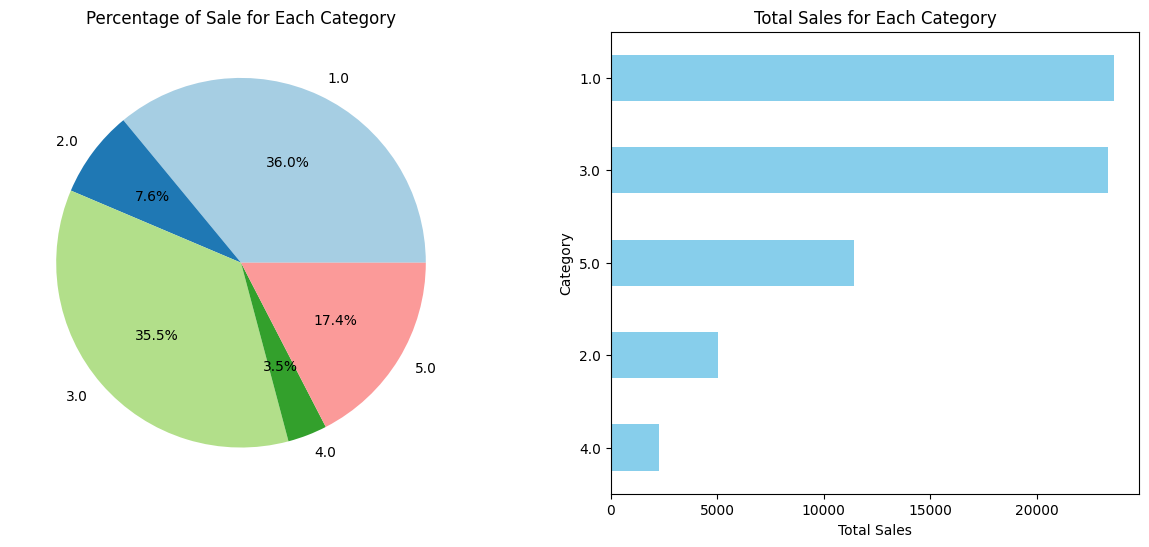

In [12]:
# What is the percentage of sale for each category?
# What is the total sales for each category?
df['Sale'] = pd.to_numeric(df['Sale'], errors='coerce')  # Convert 'Sale' column to numeric

# Group by 'Category' and calculate the sum of sales for each category
category_sales = df.groupby('Category')['Sale'].sum()

# Calculate the total sale for all categories
total_sale = category_sales.sum()

# Calculate the percentage of sale for each category
percentage_sale = (category_sales / total_sale) * 100

# Plot the pie chart
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Pie chart
axes[0].pie(percentage_sale, labels=percentage_sale.index, autopct='%1.1f%%', colors=plt.cm.Paired.colors)
axes[0].set_title('Percentage of Sale for Each Category')
axes[0].set_ylabel('')  # Remove the default 'Category' label

# Bar chart
category_sales.sort_values().plot(kind='barh', ax=axes[1], color='skyblue')
axes[1].set_title('Total Sales for Each Category')
axes[1].set_xlabel('Total Sales')

plt.show()

In [13]:
# Which is the Best Selling Product in Each Country
df['Sale'] = pd.to_numeric(df['Sale'], errors='coerce')  # Convert 'Sale' column to numeric

# Group by 'Category' and find the best-selling product in each category
best_selling_products = df.loc[df.groupby('Category')['Sale'].idxmax()]

# Display the result in a simple table format
print("Best Selling Product in Each Category:")
print("{:<20} {:<40} {:<10}".format("Category", "Name", "Sale"))
for index, row in best_selling_products.iterrows():
    print("{:<20} {:<40} {:<10}".format(row['Category'], row['Name'], row['Sale']))

Best Selling Product in Each Category:
Category             Name                                     Sale      
1.0                  Bộ Nồi Inox 3 Đáy Sunhouse SH335(16cm, 20cm, 24cm ) - Dùng trên mọi loại bếp - Hàng chính hãng 5000.0    
2.0                  Nến thơm hoa khô thiên nhiên, sáp nến thơm phòng MO hi cao cấp - Hàng chính hãng, giao màu, hình, họa tiết hộp ngẫu nhiên 1598.0    
3.0                  Gối Memory Foam 50D Hình Cong Lock&Lock HLW111 (50 x 30 cm) - Trắng 5000.0    
4.0                  Muỗng Đong Định Lượng Greenhome, 2 Đầu, Chia Vạch Sẵn, Tiện Lợi, Đong Phân Bón Dạng Bột, Gia Vị 565.0     
5.0                  Bàn Làm Việc Phong Cách Bắc Âu Thương Hiệu IGEA (Không Bao Gồm Ghế) 2863.0    


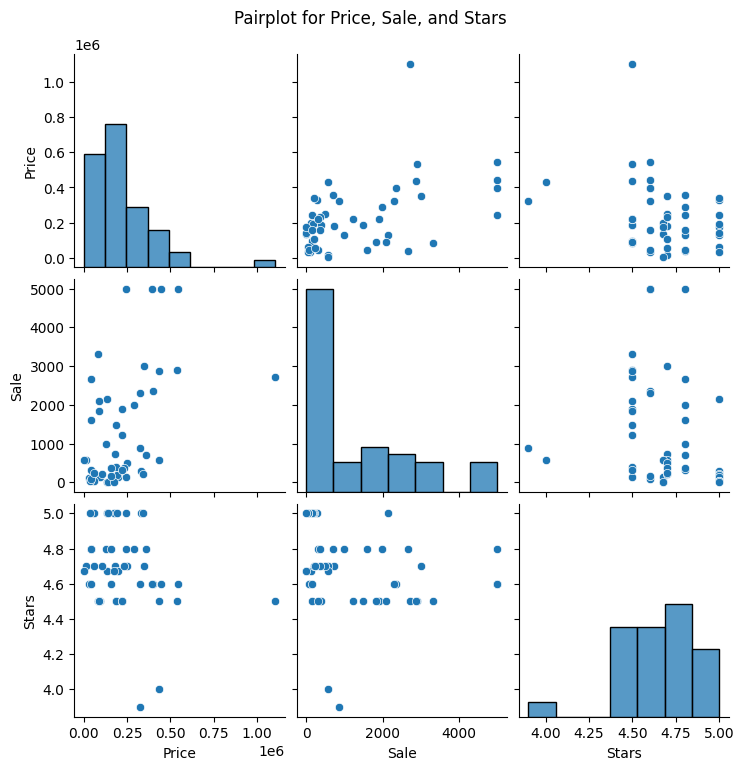

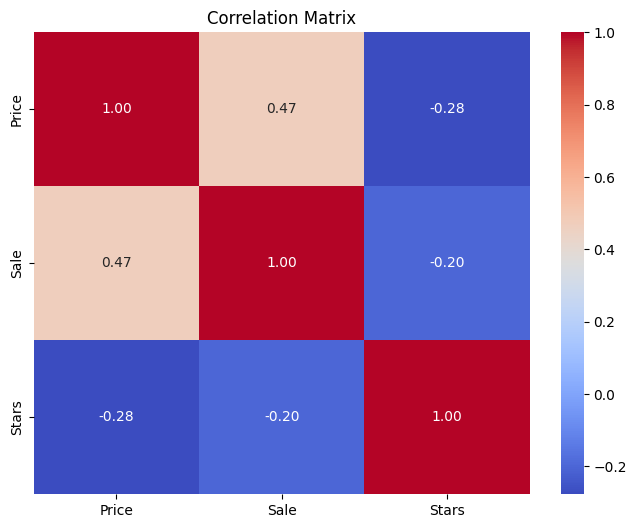

In [14]:
# STATISTICAL CALCULATIONS
# Correlations: Check correlations between variables like 'Price', 'Sale', 'Stars', and 'Reviews' to understand relationships
sns.pairplot(df[selected_columns].dropna())
plt.suptitle("Pairplot for Price, Sale, and Stars", y=1.02)
plt.show()

# Correlation matrix
correlation_matrix = df[selected_columns].corr()

# Heatmap for correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [15]:
# Split the data into two DataFrames: X (features) and y (target variable)
X = df[['Price', 'Stars', '5 stars', '4 stars', '3 stars', '2 stars', '1 star','Category', 'Number of coupon']]  # Specify at least one column as a feature
y = df["Sale"]  # Specify one column as the target variable
print(X)

        Price     Stars     5 stars     4 stars    3 stars  2 stars    1 star  \
0    445000.0  4.600000  110.000000   20.000000   8.000000      3.0   2.00000   
1    536000.0  4.500000   67.000000   18.000000   2.000000      3.0   4.00000   
2    132000.0  5.000000    5.000000    0.000000   0.000000      0.0   0.00000   
3    331000.0  5.000000   27.000000    2.000000   0.000000      0.0   0.00000   
4    349000.0  4.700000  642.000000  114.000000  24.000000     14.0  15.00000   
5    433677.0  4.000000    0.000000    1.000000   0.000000      0.0   0.00000   
6    184000.0  4.500000   46.000000   17.000000   1.000000      4.0   3.00000   
7    325000.0  3.900000    8.000000    2.000000   2.000000      1.0   2.00000   
8    399000.0  4.600000  301.000000   58.000000  10.000000      4.0  18.00000   
9    544000.0  4.600000  440.000000  110.000000  21.000000      7.0  11.00000   
10   180000.0  4.700000  124.000000   14.000000   1.000000      3.0   3.00000   
11   219000.0  4.500000  227

In [16]:
# Split the data into train and test subsets
# You can adjust the test size and random state
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=123
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((35, 9), (15, 9), (35,), (15,))

In [17]:
# Define parameters: these will need to be tuned to prevent overfitting and underfitting
params = {
    "n_estimators": 100,  # Number of trees in the forest
    "max_depth": 10,  # Max depth of the tree
    "min_samples_split": 4,  # Min number of samples required to split a node
    "min_samples_leaf": 2,  # Min number of samples required at a leaf node
    "ccp_alpha": 0,  # Cost complexity parameter for pruning
    "random_state": 123,
}

# Create a RandomForestRegressor object with the parameters above
rf = RandomForestRegressor(**params)

# Train the random forest on the train set
rf = rf.fit(X_train, y_train)

# Predict the outcomes on the test set
y_pred = rf.predict(X_test)

In [18]:
# Evaluate performance with error metrics
print("Mean Absolute Error:", metrics.mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", metrics.mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 907.0836801587299
Mean Squared Error: 1478917.9805628662
Root Mean Squared Error: 1216.1077174999205


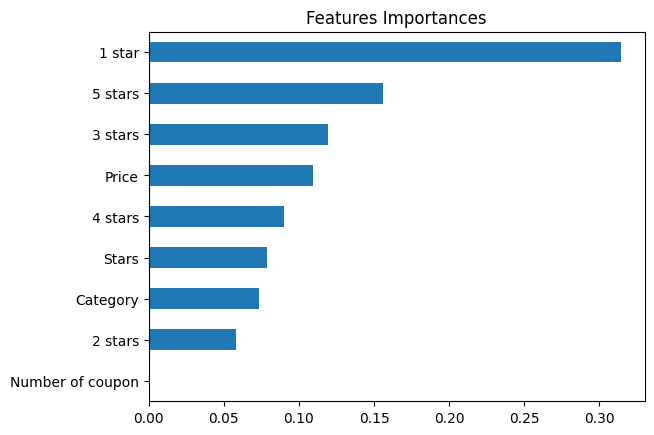

In [19]:
# Create a sorted Series of features importances
importances_sorted = pd.Series(
    data=rf.feature_importances_, index=X_train.columns
).sort_values()

# Plot a horizontal barplot of importances_sorted
importances_sorted.plot(kind="barh")
plt.title("Features Importances")
plt.show()

In [20]:
# Define a parameter grid with distributions of possible parameters to use
rs_param_grid = {
    "n_estimators": list((range(20, 200))),
    "max_depth": list((range(3, 12))),
    "min_samples_split": list((range(2, 5))),
    "min_samples_leaf": list((range(1, 5))),
    "ccp_alpha": [0, 0.001, 0.01, 0.1],
}

# Create a RandomForestRegressor
rf = RandomForestRegressor(random_state=123)

# Instantiate RandomizedSearchCV() with rf and the parameter grid
rf_rs = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rs_param_grid,
    cv=3,  # Number of folds
    n_iter=10,  # Number of parameter candidate settings to sample
    verbose=2,  # The higher this is, the more messages are outputed
    scoring="neg_mean_absolute_error",  # Metric to evaluate performance
    random_state=123
)

# Train the model on the training set
rf_rs.fit(X_train, y_train)

# Print the best parameters and highest accuracy
print("Best parameters found: ", rf_rs.best_params_)
print("Best performance: ", rf_rs.best_score_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ccp_alpha=0, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=85; total time=   0.0s
[CV] END ccp_alpha=0, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=85; total time=   0.0s
[CV] END ccp_alpha=0, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=85; total time=   0.0s
[CV] END ccp_alpha=0.001, max_depth=6, min_samples_leaf=4, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END ccp_alpha=0.001, max_depth=6, min_samples_leaf=4, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END ccp_alpha=0.001, max_depth=6, min_samples_leaf=4, min_samples_split=4, n_estimators=150; total time=   0.0s
[CV] END ccp_alpha=0, max_depth=11, min_samples_leaf=1, min_samples_split=4, n_estimators=110; total time=   0.0s
[CV] END ccp_alpha=0, max_depth=11, min_samples_leaf=1, min_samples_split=4, n_estimators=110; total time=   0.0s
[CV] END ccp_alpha=0,